In [1]:
#@title Import Modules
import math
import functools
import random

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models

from collections import Counter
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms

In [2]:
#@title Define Hyperparameters
if(torch.backends.mps.is_available()):
    device = 'mps'
elif (torch.cuda.is_available()):
    device = 'cuda'
else:
    device = 'cpu'

# Experiment parameters
tasks           = [(0,2), (5,6), (3,8)]
dataset         = datasets.MNIST
transform       = transforms.ToTensor()
train_batch_size= 512
test_batch_size = 512

# Training Parameters
epochs          = 10
offline_lr      = 7e-2
milestones      = [epochs//2]
gamma           = 0.5
batch_size      = 512
momentum        = 0
weight_decay    = 0

# Mutual Information Parameters
n_bins          = 10

In [3]:
pca_components = 12

#@title Data Retrieval
def process_data(data, task):
    conditions = []
    for c in task:
      conditions.append((data.targets == c))
    indices = functools.reduce(torch.logical_or, conditions)
    data.data, data.targets = data.data[indices], data.targets[indices]
    for i in range(len(task)):
      data.targets[data.targets == task[i]] = i
    data = TensorDataset(data.data.reshape(-1, 28*28), data.targets)
    return data

def get_loaders(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)
    test_dataset  = process_data(dataset('../data', download=True, train=False, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
    test_dataset.tensors  = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])

    # Make dataset loaders
    online_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=False
    )
    return online_loader, test_loader

def get_test_loader(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)
    test_dataset  = process_data(dataset('../data', download=True, train=False, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
    test_dataset.tensors  = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])
    test_loader   = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=False
    )
    return test_loader

def get_MI_loader(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])

    # Make dataset loaders
    MI_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=len(train_dataset), shuffle=False, drop_last=False
    )
    return MI_loader

In [4]:
def test_tasks(model, class_heads, tasks):
    # test tasks individually
    model.eval()
    test_set_accuracy = {}
    for taskNum in range(len(tasks)):
        print("        Testing task:", taskNum+1, "/", len(tasks), end=": ")
        test_loader = get_test_loader(tasks[taskNum])
        N = 0
        accuracy = 0
        for batch_idx, (images, labels) in enumerate(test_loader, start=1):
            images, labels = images.to(device), labels.to(device)

            # forward pass
            h1, h2, h3, h4, h5 = model(images)
            h6 = F.log_softmax(class_heads[taskNum](h5), dim = 1)

            # check if predicted labels are equal to true labels
            predicted_labels = torch.argmax(h6,dim=1)
            accuracy += torch.sum((predicted_labels==labels).float()).item()
            N += images.shape[0]
        print(str(round(100. * accuracy/N)) + "%")
        test_set_accuracy[taskNum] = 100. * accuracy/N

    print("        Testing global accuracy: ", end="")

    N = 0
    accuracy = 0
    for taskNum, task in enumerate(tasks):
      test_loader = get_test_loader([c for c in task])
      for batch_idx, (images, labels) in enumerate(test_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5 = model(images)
        h6 = F.log_softmax(class_heads[taskNum](h5), dim = 1)

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

    print(str(round(100. * accuracy/N)) + "%")
    total_accuracy = 100. * accuracy/N
    return total_accuracy, test_set_accuracy

In [5]:
#@title Mutual Information Computer
def compute_mutual_information(model, class_heads, taskNum, data_loader):
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

    h_list = model(images)
    h6 = F.log_softmax(class_heads[taskNum](h_list[-1]), dim = 1)
    h_list = h_list + (h6, )

    # calculate mutual information
    layers = len(h_list)
    MI_XH = torch.zeros(layers)
    MI_YH = torch.zeros(layers)
    for layer, h in enumerate(h_list):
        # discretize images and representations
        bins = np.linspace(0, 1, n_bins+1)
        x_ = np.digitize(images.cpu(), bins)
        if layer == layers-1:
            h = torch.exp(h)
            bins = np.linspace(0, 1, n_bins+1)
        else:
            bins = np.linspace(-1, 1, n_bins+1)
        h_ = np.digitize(h.cpu().detach().numpy(), bins)
        y_ = labels.cpu()

        # calculate discrete probabilities
        p_X = Counter()
        p_Y = Counter()
        p_H = Counter()
        p_XH = Counter()
        p_YH = Counter()

        for x_i, h_i, y_i in zip(x_, h_, y_):
            def totuple(a):
                try:
                    return tuple(totuple(i) for i in a)
                except:
                    return a.item()

            unit = 1./len(images)

            p_X[totuple(x_i)]                   += unit
            p_Y[totuple(y_i)]                   += unit
            p_H[totuple(h_i)]                   += unit
            p_XH[(totuple(x_i), totuple(h_i))]  += unit
            p_YH[(totuple(y_i), totuple(h_i))]  += unit

        for xh in p_XH:
            if p_XH[xh] != 0:
                MI_XH[layer] += p_XH[xh] * math.log2(p_XH[xh] / (p_X[xh[0]] * p_H[xh[1]]))

        for yh in p_YH:
            if p_YH[yh] != 0:
                MI_YH[layer] += p_YH[yh] * math.log2(p_YH[yh] / (p_Y[yh[0]] * p_H[yh[1]]))
    return MI_XH, MI_YH

In [6]:
#@title Define Model
class Model(nn.Module):
    def __init__(self):
      super(Model, self).__init__()
      self.fc1 = nn.Linear(pca_components, 10)
      self.fc2 = nn.Linear(10, 7)
      self.fc3 = nn.Linear(7, 5)
      self.fc4 = nn.Linear(5, 4)
      self.fc5 = nn.Linear(4, 3)
      self.is_online = True

    def forward(self, x):
      h1 = torch.tanh(self.fc1(x))
      h2 = torch.tanh(self.fc2(h1))
      h3 = torch.tanh(self.fc3(h2))
      h4 = torch.tanh(self.fc4(h3))
      h5 = torch.tanh(self.fc5(h4))
      return h1, h2, h3, h4, h5

In [7]:
#@title Run Experiment
# Model setup
model       = Model().to(device)
class_heads = {i : nn.Linear(3, len(tasks[0])).to(device) for i in range(len(tasks))}
loss_function = nn.NLLLoss()

# Test Setup
test_set_accuracy   = {}

# Mutual Information Setup
MI_loader   = get_MI_loader(tasks[0])
layers      = len(list(model.children())) + 1
MI_XH_tasks = torch.zeros(len(tasks), epochs, layers)
MI_YH_tasks = torch.zeros(len(tasks), epochs, layers) 

Pre-Training
        Epoch: 1,2,3,4,5,6,7,8,9,10,

<Figure size 640x480 with 0 Axes>

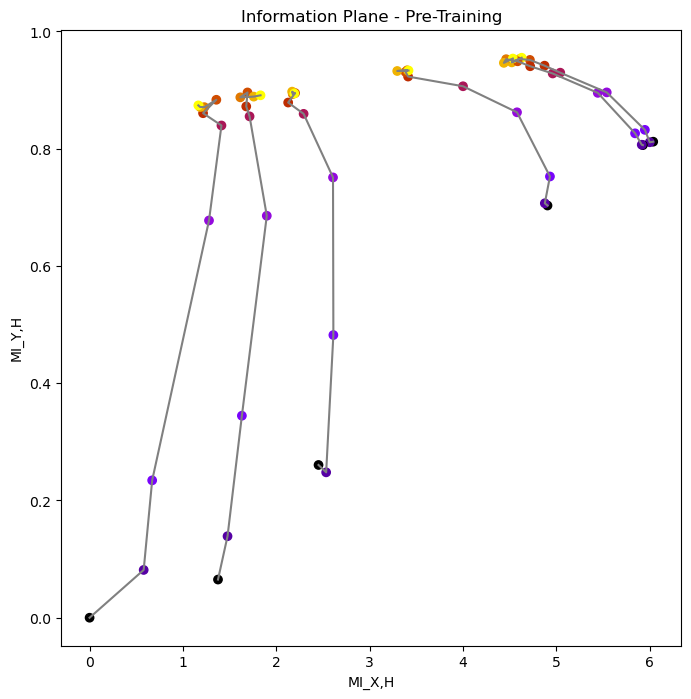

done!
        Train accuracy: 83.95295516304348
    Testing Across Tasks
        Testing task: 1 / 1: 98%
        Testing global accuracy: 98%


In [8]:
# Pre-training

task = tasks[0]
taskNum = 0
print("Pre-Training")
accuracy = 0
N = 0

model.train()
parameters = list(model.parameters()) + list(class_heads[taskNum].parameters())
optimizer = optim.SGD(parameters,
                        lr=offline_lr,
                        momentum=momentum,
                        weight_decay=weight_decay)
train_loader, test_loader = get_loaders(tasks[taskNum])

print("        Epoch: ", end="")
for epoch in range(epochs):
    print(str(epoch+1) + ",", end="")
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5 = model(images)
        h6 = F.log_softmax(class_heads[taskNum](h5), dim = 1)
        loss = loss_function(h6, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]


        ### Calculate Mutual ###

        MI_XH, MI_YH = compute_mutual_information(model, class_heads, taskNum, MI_loader)
        MI_XH_tasks[taskNum, epoch] = MI_XH
        MI_YH_tasks[taskNum, epoch] = MI_YH

plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('MI_X,H')
ax.set_ylabel('MI_Y,H')
title = ax.set_title(f'Information Plane - Pre-Training')
cmap = plt.get_cmap('gnuplot', epochs)
colors = [cmap(i) for i in np.linspace(0, 1, epochs)]
ax.plot(MI_XH_tasks[taskNum], MI_YH_tasks[taskNum], '-', color='gray')
for layer in range(layers):
    im = ax.scatter(MI_XH_tasks[taskNum, :,layer], MI_YH_tasks[taskNum, :,layer], c=colors)

plt.show()

print("done!")
print("        Train accuracy:", 100. * accuracy/N)
print("    Testing Across Tasks")
overall, specific = test_tasks(model, class_heads, tasks[:taskNum+1])
test_set_accuracy[taskNum] = specific[taskNum, epoch] = MI_YH

Task: 2 / 2
        Epoch: 1,2,3,4,5,6,7,8,9,10,

<Figure size 640x480 with 0 Axes>

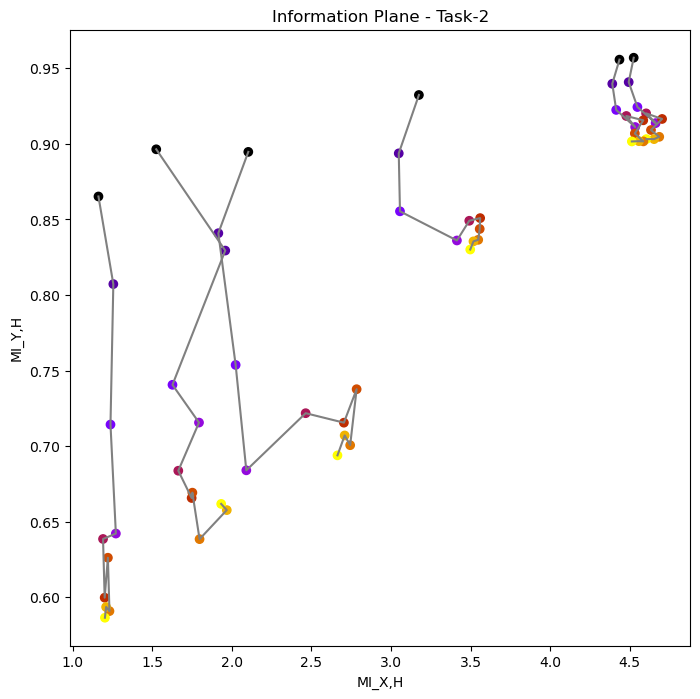

done!
        Train accuracy: 92.29225852272727
    Testing Across Tasks
        Testing task: 1 / 2: 91%
        Testing task: 2 / 2: 96%
        Testing global accuracy: 94%
Task: 3 / 2
        Epoch: 1,2,3,4,5,6,7,8,9,10,

<Figure size 640x480 with 0 Axes>

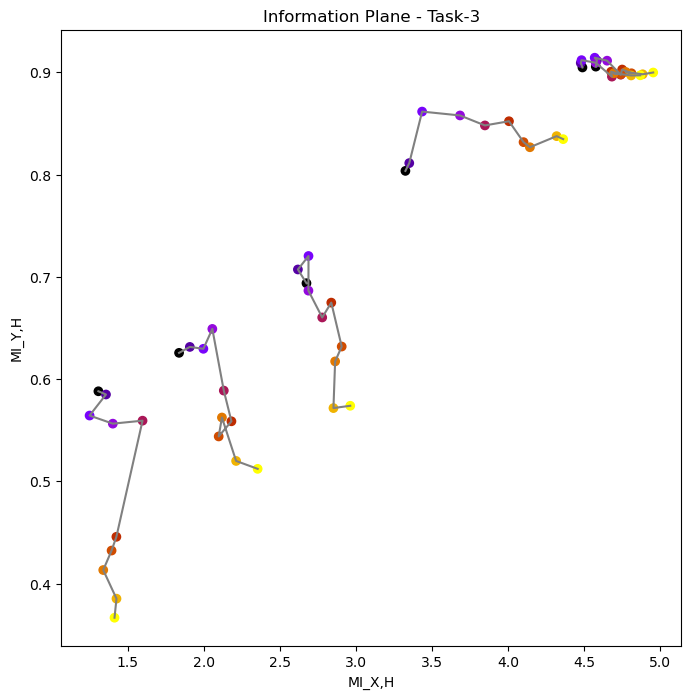

done!
        Train accuracy: 88.77632472826087
    Testing Across Tasks
        Testing task: 1 / 3: 76%
        Testing task: 2 / 3: 82%
        Testing task: 3 / 3: 94%
        Testing global accuracy: 84%


In [9]:
# Online Training
for taskNum in range(1, len(tasks)):
    print("Task:", taskNum+1, "/", len(tasks) - 1)
    accuracy = 0
    N = 0

    model.train()
    parameters = list(model.parameters()) + list(class_heads[taskNum].parameters())
    optimizer = optim.SGD(parameters,
                          lr=offline_lr,
                          momentum=momentum,
                          weight_decay=weight_decay)
    train_loader, test_loader = get_loaders(tasks[taskNum])

    print("        Epoch: ", end="")
    for epoch in range(epochs):
        print(str(epoch+1) + ",", end="")
        for batch_idx, (images, labels) in enumerate(train_loader, start=1):
            images, labels = images.to(device), labels.to(device)

            # forward pass
            h1, h2, h3, h4, h5 = model(images)
            h6 = F.log_softmax(class_heads[taskNum](h5), dim = 1)
            loss = loss_function(h6, labels)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # check if predicted labels are equal to true labels
            predicted_labels = torch.argmax(h6,dim=1)
            accuracy += torch.sum((predicted_labels==labels).float()).item()
            N += images.shape[0]


        ### Calculate Mutual Information Offline Phase ###

        MI_XH, MI_YH = compute_mutual_information(model, class_heads, taskNum, MI_loader)
        MI_XH_tasks[taskNum, epoch] = MI_XH
        MI_YH_tasks[taskNum, epoch] = MI_YH

    plt.figure()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlabel('MI_X,H')
    ax.set_ylabel('MI_Y,H')
    title = ax.set_title(f'Information Plane - Task-{taskNum+1}')
    cmap = plt.get_cmap('gnuplot', epochs)
    colors = [cmap(i) for i in np.linspace(0, 1, epochs)]
    ax.plot(MI_XH_tasks[taskNum], MI_YH_tasks[taskNum], '-', color='gray')
    for layer in range(layers):
        im = ax.scatter(MI_XH_tasks[taskNum, :,layer], MI_YH_tasks[taskNum, :,layer], c=colors)

    plt.show()

    print("done!")
    print("        Train accuracy:", 100. * accuracy/N)
    print("    Testing Across Tasks")
    overall, specific = test_tasks(model, class_heads, tasks[:taskNum+1])
    test_set_accuracy[taskNum] = specific[taskNum, epoch] = MI_YH

MovieWriter imagemagick unavailable; using Pillow instead.


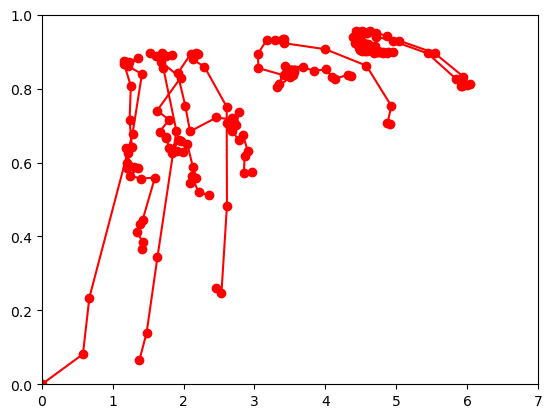

In [14]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# PLot the animations


In [11]:
data = [list(zip(MI_XH, MI_YH)) for MI_XH, MI_YH in list(zip(MI_XH_tasks.view(-1, layers).T, MI_YH_tasks.view(-1, layers).T))]
len(data)

6

In [12]:
#@title Compute Forgetting Metrics
ave_accuracy        = []
ave_inc_accuracy    = []
forgetting_measure  = []
backward_transfer   = []

# Compute average accuracy
for taskNum in range(len(tasks)):
    ave_accuracy.append(0)
    for testTaskNum in range(taskNum+1):
      ave_accuracy[-1] += test_set_accuracy[taskNum][testTaskNum]
    ave_accuracy[-1] = ave_accuracy[-1] / (taskNum+1)

# Compute average incremental accuracy
for taskNum in range(len(tasks)):
    ave_inc_accuracy.append(0)
    for testTaskNum in range(taskNum+1):
      ave_inc_accuracy[-1] += ave_accuracy[testTaskNum]
    ave_inc_accuracy[-1] = ave_inc_accuracy[-1] / (taskNum+1)

# Compute forgetting measure
for taskNum in range(1,len(tasks)):
    forgetting_measure.append(0)
    for testTaskNum in range(taskNum):
      f = -math.inf
      for i in range(testTaskNum, taskNum):
        if test_set_accuracy[i][testTaskNum] > f:
          f = test_set_accuracy[i][testTaskNum]
      forgetting_measure[-1] += f - test_set_accuracy[taskNum][testTaskNum]
    forgetting_measure[-1] = forgetting_measure[-1] / taskNum

# Compute backward transfer
for taskNum in range(1, len(tasks)):
    backward_transfer.append(0)
    for testTaskNum in range(taskNum):
      backward_transfer[-1] += test_set_accuracy[taskNum][testTaskNum] - test_set_accuracy[testTaskNum][testTaskNum]
    backward_transfer[-1] = backward_transfer[-1] / taskNum

print("Average Accuracy:", ave_accuracy)
print("Average Incremental Accuracy:", ave_inc_accuracy)
print("Forgetting Measure:", forgetting_measure)
print("Backward Transfer:", backward_transfer)

Average Accuracy: [tensor(0.9552), tensor(0.9024), tensor(0.8772)]
Average Incremental Accuracy: [tensor(0.9552), tensor(0.9288), tensor(0.9116)]
Forgetting Measure: [tensor(0.0520), tensor(0.0300)]
Backward Transfer: [tensor(-0.0520), tensor(-0.0300)]


NameError: name 'XH_data' is not defined

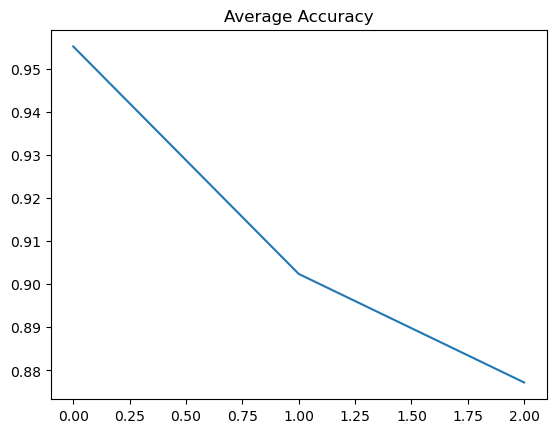

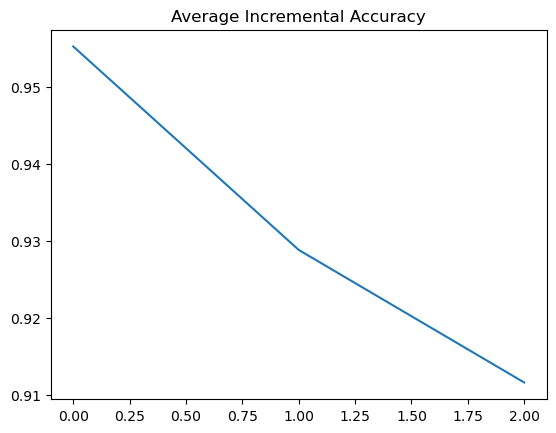

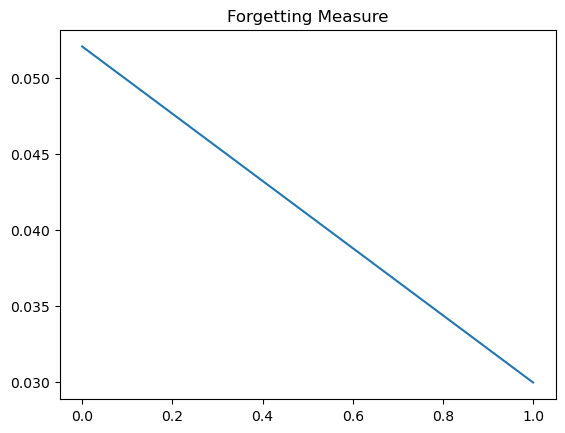

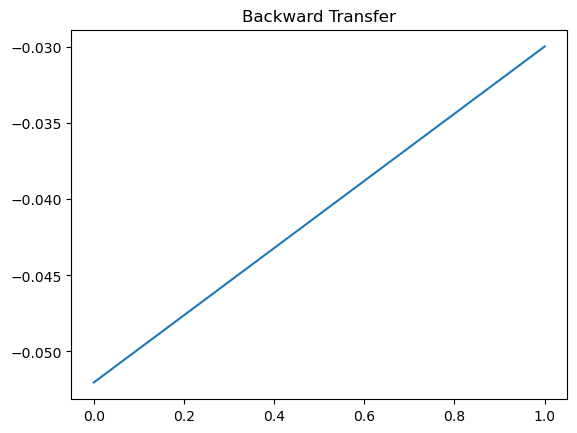

<Figure size 640x480 with 0 Axes>

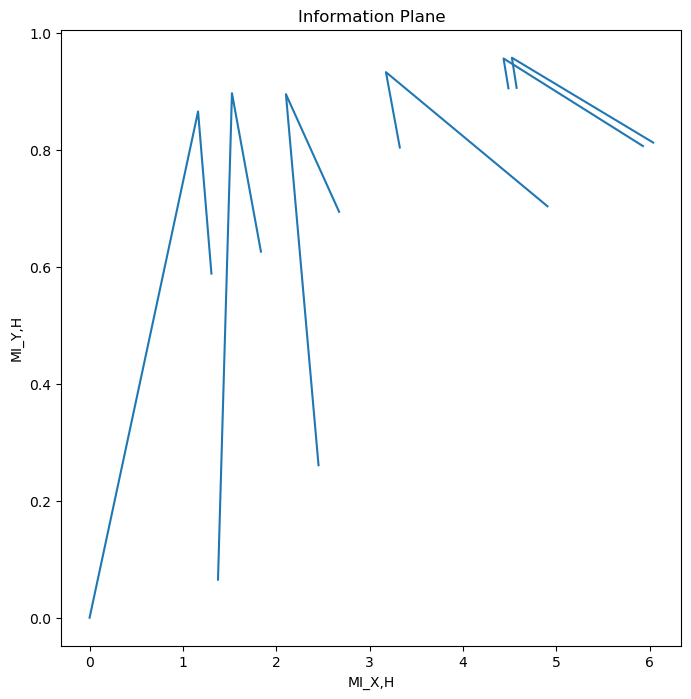

In [13]:
#@title Plot Results
# Plot average accuracy
plt.figure()
plt.title("Average Accuracy")
plt.plot(ave_accuracy)

# Plot average incremental accuracy
plt.figure()
plt.title("Average Incremental Accuracy")
plt.plot(ave_inc_accuracy)

# Plot forgetting measure
plt.figure()
plt.title("Forgetting Measure")
plt.plot(forgetting_measure)

# Plot backward transfer
plt.figure()
plt.title("Backward Transfer")
plt.plot(backward_transfer)

# Construct figure
plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('MI_X,H')
ax.set_ylabel('MI_Y,H')
title = ax.set_title('Information Plane')

# Construct task colour map (for dots)
cmap_dots = plt.get_cmap('gnuplot', len(tasks))
dot_colors = [cmap_dots(i) for i in np.arange(0, len(tasks))]

# Construct layer colour map (for lines)
cmap_lines = plt.get_cmap('tab10', layers)
line_colors = [cmap_lines(i) for i in np.arange(0, layers)]
for layer in range(layers):
    ax.plot(MI_XH_tasks[:,layer], MI_YH_tasks[:,layer], '-', color=line_colors[layer], label="Layer " + str(layer+1))
    im = ax.scatter(XH_data, YH_data, c=dot_colors)
ax.legend()